##**Importing all requisite libraries:-**

In [1]:
!pip install catboost
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.layers import Input, Dense, Dropout
from keras.models import Model
import random
import scipy.stats
import os
import tensorflow as tf
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error as mse
from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


## **Loading of data into the DataFrame:-**

In [2]:
train=pd.read_csv(r"train_IxoE5JN.csv")
train.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


## **Splitting of datetime into seperate columns:-**

In [3]:
test = pd.read_csv(r"test_WudNWDM.csv",parse_dates=['datetime'])
test['year'] = test['datetime'].dt.year
test['month'] =test['datetime'].dt.month
test['day'] =test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour



In [4]:
test.head()

,row_id,datetime,year,month,day,hour
0,94993,2019-01-01 00:00:00,2019,1,1,0
1,94994,2019-01-01 01:00:00,2019,1,1,1
2,94995,2019-01-01 02:00:00,2019,1,1,2
3,94996,2019-01-01 03:00:00,2019,1,1,3
4,94997,2019-01-01 04:00:00,2019,1,1,4


In [5]:
test.isna().sum()

row_id      0
datetime    0
year        0
month       0
day         0
hour        0
dtype: int64

In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    26304 non-null  int64         
 1   datetime  26304 non-null  datetime64[ns]
 2   year      26304 non-null  int64         
 3   month     26304 non-null  int64         
 4   day       26304 non-null  int64         
 5   hour      26304 non-null  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 1.2 MB


In [7]:
train = pd.read_csv(r"train_IxoE5JN.csv",parse_dates=['datetime'])
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour



In [8]:
train.head()

,row_id,datetime,energy,year,month,day,hour
0,1,2008-03-01 00:00:00,1259.985563,2008,3,1,0
1,2,2008-03-01 01:00:00,1095.541500,2008,3,1,1
2,3,2008-03-01 02:00:00,1056.247500,2008,3,1,2
3,4,2008-03-01 03:00:00,1034.742000,2008,3,1,3
4,5,2008-03-01 04:00:00,1026.334500,2008,3,1,4


In [9]:
train.describe()

,row_id,energy,year,month,day,hour
count,94992.000000,93092.000000,94992.000000,94992.000000,94992.000000,94992.000000
mean,47496.500000,1702.995014,2013.075038,6.599040,15.733704,11.500000
std,27421.972723,369.322103,3.125436,3.417591,8.802197,6.922223
min,1.000000,866.388600,2008.000000,1.000000,1.000000,0.000000
25%,23748.750000,1431.541100,2010.000000,4.000000,8.000000,5.750000
50%,47496.500000,1654.465800,2013.000000,7.000000,16.000000,11.500000
75%,71244.250000,1935.993450,2016.000000,10.000000,23.000000,17.250000
max,94992.000000,3374.399600,2018.000000,12.000000,31.000000,23.000000


## **Data Cleaning:-**

In [11]:
train.isna().sum()

row_id         0
datetime       0
energy      1900
year           0
month          0
day            0
hour           0
dtype: int64

In [12]:
df=train.copy()

In [13]:
df=df.drop(['datetime'], axis=1)

## **Arranging in proper sequnence i.e. target column at last:**-

In [14]:
df1=df.iloc[:,0:1]
df2=df.iloc[:,2:6]
df3=df.iloc[:,1:2]
res=pd.concat([df1,df2,df3], axis=1)

In [15]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   row_id  94992 non-null  int64  
 1   year    94992 non-null  int64  
 2   month   94992 non-null  int64  
 3   day     94992 non-null  int64  
 4   hour    94992 non-null  int64  
 5   energy  93092 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 4.3 MB


In [16]:
res.isna().sum()

row_id       0
year         0
month        0
day          0
hour         0
energy    1900
dtype: int64

In [17]:
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor

df_mice =  train.filter(['row_id','year','month','day','hour','energy'], axis=1).copy()


# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=5), n_nearest_features=None,max_iter=100, tol=0.001,initial_strategy='mean', imputation_order='ascending')

df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

In [18]:
df_mice_imputed

,row_id,year,month,day,hour,energy
0,1.0,2008.0,3.0,1.0,0.0,1259.985563
1,2.0,2008.0,3.0,1.0,1.0,1095.541500
2,3.0,2008.0,3.0,1.0,2.0,1056.247500
3,4.0,2008.0,3.0,1.0,3.0,1034.742000
4,5.0,2008.0,3.0,1.0,4.0,1026.334500
...,...,...,...,...,...,...
94987,94988.0,2018.0,12.0,31.0,19.0,2528.446800
94988,94989.0,2018.0,12.0,31.0,20.0,2461.883600
94989,94990.0,2018.0,12.0,31.0,21.0,2365.994400
94990,94991.0,2018.0,12.0,31.0,22.0,2342.942800


In [19]:
df_mice_imputed['year'] = df_mice_imputed['year'].astype(int)
df_mice_imputed['month'] = df_mice_imputed['month'].astype(int)
df_mice_imputed['day'] = df_mice_imputed['day'].astype(int)
df_mice_imputed['hour'] = df_mice_imputed['hour'].astype(int)
df_mice_imputed['row_id'] = df_mice_imputed['row_id'].astype(int)

In [208]:
#res1=df_mice_imputed.drop(['row_id'],axis=1)

In [ ]:
#res1

In [20]:
res=df_mice_imputed.copy()

In [21]:
res

,row_id,year,month,day,hour,energy
0,1,2008,3,1,0,1259.985563
1,2,2008,3,1,1,1095.541500
2,3,2008,3,1,2,1056.247500
3,4,2008,3,1,3,1034.742000
4,5,2008,3,1,4,1026.334500
...,...,...,...,...,...,...
94987,94988,2018,12,31,19,2528.446800
94988,94989,2018,12,31,20,2461.883600
94989,94990,2018,12,31,21,2365.994400
94990,94991,2018,12,31,22,2342.942800


In [ ]:
#res1.isna().sum()

In [22]:
res.isna().sum()

row_id    0
year      0
month     0
day       0
hour      0
energy    0
dtype: int64

In [168]:
# Imputing with KNNImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler



# Define scaler to set values between 0 and 1

df_knn = train.filter(['year','month','day','hour','energy'], axis=1).copy()

# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

In [169]:
df_knn_imputed

,year,month,day,hour,energy
0,0.0,0.181818,0.0,0.000000,0.156936
1,0.0,0.181818,0.0,0.043478,0.091368
2,0.0,0.181818,0.0,0.086957,0.075701
3,0.0,0.181818,0.0,0.130435,0.067126
4,0.0,0.181818,0.0,0.173913,0.063774
...,...,...,...,...,...
94987,1.0,1.000000,1.0,0.826087,0.662700
94988,1.0,1.000000,1.0,0.869565,0.636159
94989,1.0,1.000000,1.0,0.913043,0.597926
94990,1.0,1.000000,1.0,0.956522,0.588735


## **Train-Test Split:-**

In [ ]:
#X = res1.drop(['energy'], axis=1)
#y = res1['energy']

In [24]:
X = res.drop(['energy'], axis=1)
y = res['energy']

In [170]:
#X = df_knn_imputed.drop(['energy'], axis=1)
#y = df_knn_imputed['energy']

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=2022, test_size=0.2)


In [26]:
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((75993, 5), (18999, 5), (75993,), (18999,))

##**Standardizing the samples:**-

In [27]:
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_train)
    X_va_f = preproc.transform(X_val)

# **Different Machine Learning Models:**-

# **1. Linear Regression:**-

In [28]:
model = LinearRegression()
model.fit(X_train, y_train)
print("Test R^2 Score: {:.5f}".format(model.score(X_val, y_val)))

Test R^2 Score: 0.49414


In [29]:
model = LinearRegression()
model.fit(X_tr_f , y_train)
print("Test R^2 Score: {:.5f}".format(model.score(X_va_f, y_val)))

Test R^2 Score: 0.49414


# **2. Random Forest:**-

In [30]:
regr = RandomForestRegressor(n_estimators = 10, max_depth = 4, random_state = 101)
regr.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=4, n_estimators=10, random_state=101)

In [31]:
predictions = regr.predict(X_val)


In [32]:
mae = mean_absolute_error(y_val.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_val.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_val.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 2))

Mean Absolute Error: 174.53
Mean Squared Error: 50481.28
R-squared scores: 0.63


# **3. CatBoost:**-

In [33]:
model2=CatBoostRegressor()
model2.fit(X_train, y_train)
print("Test R^2 Score: {:.5f}".format(model2.score(X_val, y_val)))


Learning rate set to 0.08116
0:	learn: 350.6475086	total: 58.7ms	remaining: 58.6s
1:	learn: 333.7372595	total: 69.7ms	remaining: 34.8s
2:	learn: 318.9424561	total: 80.3ms	remaining: 26.7s
3:	learn: 306.5278105	total: 90.4ms	remaining: 22.5s
4:	learn: 294.0088846	total: 101ms	remaining: 20.2s
5:	learn: 282.7117027	total: 112ms	remaining: 18.5s
6:	learn: 272.8672591	total: 122ms	remaining: 17.3s
7:	learn: 263.7874794	total: 132ms	remaining: 16.4s
8:	learn: 255.8934941	total: 142ms	remaining: 15.6s
9:	learn: 248.9225884	total: 155ms	remaining: 15.3s
10:	learn: 242.9919889	total: 164ms	remaining: 14.8s
11:	learn: 237.4309974	total: 176ms	remaining: 14.5s
12:	learn: 232.6354132	total: 187ms	remaining: 14.2s
13:	learn: 228.0770149	total: 206ms	remaining: 14.5s
14:	learn: 223.5329003	total: 219ms	remaining: 14.4s
15:	learn: 220.0311538	total: 229ms	remaining: 14.1s
16:	learn: 217.3301880	total: 238ms	remaining: 13.8s
17:	learn: 214.1395227	total: 248ms	remaining: 13.5s
18:	learn: 211.3074723	

# **4. XGBoost:**-

In [34]:
def XGBoost(X_train,X_val,y_train,y_test):
    dtrain = xgb.DMatrix(X_train,label=y_train)
    dtest = xgb.DMatrix(X_val,label=y_test)

    return xgb.train(params={'objective':'reg:squarederror','eval_metric':'rmse', 'max_depth':7, 'colsample_bytree':0.9, 'gamma':1}
                    ,dtrain=dtrain,num_boost_round=4000, 
                    early_stopping_rounds=30,evals=[(dtest,'test')])

In [35]:
xgb_model = XGBoost(X_train,X_val,y_train,y_val)

[0]	test-rmse:1228.24
Will train until test-rmse hasn't improved in 30 rounds.
[1]	test-rmse:868.724
[2]	test-rmse:623.275
[3]	test-rmse:450.987
[4]	test-rmse:335.167
[5]	test-rmse:259.546
[6]	test-rmse:212.249
[7]	test-rmse:183.391
[8]	test-rmse:166.664
[9]	test-rmse:157.299
[10]	test-rmse:151.347
[11]	test-rmse:147.583
[12]	test-rmse:145.668
[13]	test-rmse:143.982
[14]	test-rmse:142.278
[15]	test-rmse:140.486
[16]	test-rmse:139.329
[17]	test-rmse:138.11
[18]	test-rmse:137.682
[19]	test-rmse:136.684
[20]	test-rmse:135.783
[21]	test-rmse:134.397
[22]	test-rmse:133.764
[23]	test-rmse:133.515
[24]	test-rmse:131.731
[25]	test-rmse:131.467
[26]	test-rmse:130.738
[27]	test-rmse:129.895
[28]	test-rmse:128.723
[29]	test-rmse:128.122
[30]	test-rmse:127.791
[31]	test-rmse:126.07
[32]	test-rmse:124.797
[33]	test-rmse:124.31
[34]	test-rmse:124.157
[35]	test-rmse:123.356
[36]	test-rmse:122.468
[37]	test-rmse:122.318
[38]	test-rmse:121.868
[39]	test-rmse:121.12
[40]	test-rmse:119.386
[41]	test-rmse

In [36]:
y_train_pred = xgb_model.predict(xgb.DMatrix(X_train), ntree_limit = xgb_model.best_iteration)
y_val_pred = xgb_model.predict(xgb.DMatrix(X_val), ntree_limit = xgb_model.best_iteration)

In [37]:
from sklearn.metrics import mean_squared_error as mse

## **Best iteration values:**-

In [38]:
print("Train set error: ", np.sqrt(mse(y_train, y_train_pred)))
print("Validation set error: ", np.sqrt(mse(y_val, y_val_pred)))

Train set error:  6.81078651325431
Validation set error:  27.282310099670724


##**Decision Tree:**-

In [39]:
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")
dtc=DecisionTreeRegressor(random_state=2022)
dtc.fit(X_train, y_train)
print("Test R^2 Score: {:.5f}".format(dtc.score(X_val, y_val)))

Test R^2 Score: 0.95943


## **Prediction from test data:**-

In [40]:
test_key = test['datetime']
x_pred = test.drop(columns=['datetime'])


In [41]:
x_pred

,row_id,year,month,day,hour
0,94993,2019,1,1,0
1,94994,2019,1,1,1
2,94995,2019,1,1,2
3,94996,2019,1,1,3
4,94997,2019,1,1,4
...,...,...,...,...,...
26299,121292,2021,12,31,19
26300,121293,2021,12,31,20
26301,121294,2021,12,31,21
26302,121295,2021,12,31,22


In [42]:
xgb_model

In [43]:
#x1=x_pred.drop(['row_id'], axis=1)

In [ ]:
#x1

In [254]:
#prediction_pr = xgb_model.predict(xgb.DMatrix(x1))

In [44]:
prediction_pr = xgb_model.predict(xgb.DMatrix(x_pred))

In [45]:
prediction_1 = prediction_pr.round(2)


In [46]:
prediction_1

array([1742.29, 1532.14, 1543.24, ..., 2373.53, 2342.2 , 2212.48],
      dtype=float32)

In [96]:
#prediction_pr = gcv.predict((x1))

In [97]:
#prediction_1 = prediction_pr.round(2)

In [135]:
#prediction_pr = dtc.predict((x1))

In [136]:
#prediction_1 = prediction_pr.round(2)

In [141]:
#prediction_pr = model2.predict((x1))

In [142]:
#prediction_1 = prediction_pr.round(2)

## **Submission of requisite file:**-

In [47]:
submission = pd.read_csv(r"sample_submission_jn0a7vR.csv")

In [48]:
submission['energy']=prediction_1

In [49]:
submission

,row_id,energy
0,94993,1742.290039
1,94994,1532.140015
2,94995,1543.239990
3,94996,1491.959961
4,94997,1474.550049
...,...,...
26299,121292,2507.280029
26300,121293,2442.870117
26301,121294,2373.530029
26302,121295,2342.199951


In [50]:
submission.to_csv("submission.csv",index=False)

## **XGboost Feature Importance:**-

Plotting Feature Importance


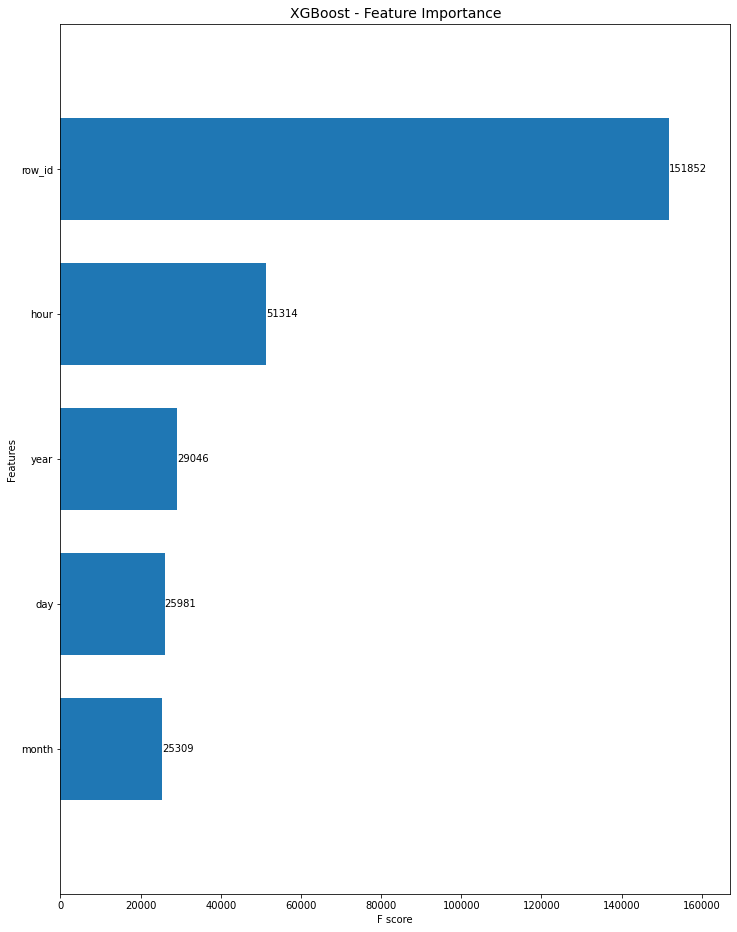

In [51]:
print('Plotting Feature Importance')
fig, ax = plt.subplots(figsize=(12,16))
xgb.plot_importance(xgb_model, height=0.7, ax=ax)
ax.grid(False)
plt.title("XGBoost - Feature Importance", fontsize=14)
plt.show()